In [1]:
using CSV, DataFrames, Statistics
using PyPlot # plotting library
using PyCall
using Printf
using FStrings
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"

# check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-pastel")

# change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

#make jupyter notebook print more dataframe columns
ENV["COLUMNS"]=160

# important attributes for this analysis
hand = "basic"
subjects = ["sub1", "sub2", "sub3"]
t_labels = ["a", "b", "c", "d", "e", "f", "g", "h"]
rotations = ["n"]
translations = ['a','b','c','d','e','f','g','h']

metrics = [:dist, :arc_len, :area_btwn, :max_a_loc, :max_a_reg, :max_err, :mvt_eff, :t_fd, :r_fd]
metric_sds = [:dist_sd, :arc_len, :area_btwn_sd, :max_a_loc_sd, :max_a_reg_sd, :max_err_sd, :mvt_eff_sd, :t_fd_sd, :r_fd_sd]

metric_to_color = Dict(:dist=>"xkcd:tan", :arc_len=>"xkcd:light blue", :area_btwn=>"xkcd:dark red", :max_a_loc=>"xkcd:light green", :max_a_reg=>"xkcd:dark green", :max_err=>"xkcd:blue grey", :mvt_eff=>"xkcd:dark orange", :r_fd=>"xkcd:red brown", :t_fd=>"xkcd:brown")


print("Ready to go!")

Ready to go!

-----

# Reading in the Data
Now reading in the metrics data for 2v2.

In [2]:
df_hand = CSV.read(f"results/{hand}_metrics.csv", DataFrame, copycols=true)
df_hand_avg = CSV.read(f"results/{hand}_avg_metrics.csv", DataFrame, copycols=true)
df_hand_std = CSV.read(f"results/{hand}_metric_sds.csv", DataFrame, copycols=true)
first(df_hand, 23)

,trial,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_basic_a_n_1,0.0228927,6.57678e-5,0.00505051,0.0,0.0,0.011,0.220616,0.5143,0.0114702
2,sub1_basic_a_n_2,0.0295363,5.77915e-5,0.00505051,0.0,0.0,0.0049,0.170993,0.4406,0.0111463
3,sub1_basic_a_n_3,0.0306213,4.37218e-5,0.00505051,0.0,0.0,0.0037,0.164934,0.6955,0.0135204
4,sub1_basic_a_n_4,0.0137633,4.64978e-5,0.00505051,0.0,0.0,0.0,0.366954,0.2556,0.0132041
5,sub1_basic_a_n_5,0.006,missing,0.010101,0.0,0.0,0.0012,1.6835,0.0,0.00379473
6,sub2_basic_a_n_1,0.0079,2.06537e-5,0.00505051,0.0,0.0,0.0049,0.639304,0.7572,0.00994189
7,sub2_basic_a_n_2,0.0482012,7.97231e-5,0.00505051,0.0,0.0,0.0232,0.10478,1.2241,0.0234776
8,sub2_basic_a_n_3,0.0,0.0,0.00505051,0.0,0.0,0.0,Inf,0.0,0.00505051
9,sub2_basic_a_n_4,0.00306333,missing,0.010101,0.0,0.0,0.0,3.29739,0.0,0.00295466


In [3]:
# breaking out important info from the trial id for easier data access

function condition_df(df::DataFrame)
    subject_nums = []
    translation_labels = []
    numbers = []
    for row in eachrow(df)
        label = row[:trial]
        #sub1_2v2_a_n_1
    #     push!(subject_nums, x[4])
    #     push!(translation_labels,x[10])
    #     push!(numbers, x[14])
        x = split(label, "_")
        push!(subject_nums, x[1][4])
        push!(translation_labels, x[3][1])
        push!(numbers, x[5][1])
    end
    s = convert(Array{Char,1}, subject_nums)
    d = convert(Array{Char,1}, translation_labels)
    n = convert(Array{Char,1}, numbers)

    insertcols!(df, 2, :subj=>s)
    insertcols!(df, 3, :dir=>d)
    insertcols!(df, 4, :num=>n)
end

condition_df(df_hand)
condition_df(df_hand_avg)
condition_df(df_hand_std)

first(df_hand, 2)

,trial,subj,dir,num,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Char,Char,Char,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_basic_a_n_1,1,a,1,0.0228927,6.57678e-5,0.00505051,0.0,0.0,0.011,0.220616,0.5143,0.0114702
2,sub1_basic_a_n_2,1,a,2,0.0295363,5.77915e-5,0.00505051,0.0,0.0,0.0049,0.170993,0.4406,0.0111463


## Asterisk Plot

![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

-----

# Histograms of Metrics
Now I will produce histogram plots of the metrics to see what kind of a distribution we get for all the trials.
Shamelessly taken from my previous datascience course at: [link](https://github.com/SimonEnsemble/data_science_course)

In [4]:

for m in metrics
    figure()
    hist(df_hand[:, m], color=metric_to_color[m]) #, normed=true)
    scatter(df_hand[:, m], [-1 for i = 1:nrow(df_hand)], marker="+", color="r")
    xlabel(f"{m}")
    ylabel("# Trials")
    title(f"Distribution of {m} values")
end

LoadError: [91mPyError ($(Expr(:escape, :(ccall(#= /home/cras/.julia/packages/PyCall/tqyST/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>[39m
[91mTypeError("'<=' not supported between instances of 'float' and 'PyCall.jlwrap'")[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2610, in hist[39m
[91m    if data is not None else {}), **kwargs)[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1565, in inner[39m
[91m    return func(ax, *map(sanitize_sequence, args), **kwargs)[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 6630, in hist[39m
[91m    xmin = min(xmin, np.nanmin(xi))[39m
[91m  File "<__array_function__ internals>", line 6, in nanmin[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py", line 326, in nanmin[39m
[91m    res = np.amin(a, axis=axis, out=out, **kwargs)[39m
[91m  File "<__array_function__ internals>", line 6, in amin[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 2831, in amin[39m
[91m    keepdims=keepdims, initial=initial, where=where)[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 87, in _wrapreduction[39m
[91m    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)[39m


### Observations of Histogram Plots
Based on what I see, here are the observations per metric (in order of appearance top to down):
* **total distance**: values are distributed
* **arc length**: mostly concentrated at low arc lengths
* **max area region location**: mostly, the region of max error area is most commonly found at the end
* **max area region**: at the locations of max error area, the area of error (aka the area between the path and the target line) is still relatively low
* **max error**: values are distributed
* **movement efficiency**: values are distributed
* **rotational frechet distance**: aka max rotation error. Mostly low, but larger distribution at the low end
* translational frechet distance: all values are very low

----

# Metric Values by direction
Plot all metric values in bar charts by direction

In [5]:
# groups = groupby(df_hand, :dir)
# a_df = groups[1]
# b_df = groups[2]
# c_df = groups[3]
# d_df = groups[4]
# e_df = groups[5]
# f_df = groups[6]
# g_df = groups[7]
# h_df = groups[8]
# directions = [a_df, b_df, c_df, d_df, e_df, f_df, g_df, h_df]
# a_df

In [6]:
function compare_metrics(metric::Symbol, df::DataFrame) 
    dir_data = groupby(df, :dir)
    metric_data = []
    
    for dir in dir_data
        data = dir[!, metric]
        push!(metric_data, data)
    end
    plt_title = f"{hand}: {metric}"
    boxplot(metric_data)
    title(plt_title)
    xticks(1:8, t_labels)
    xlabel("Trial Directions")
end

println("Functions are ready!")

Functions are ready!


In [7]:
subjects = ["sub1", "sub2", "sub3"]
translations = ['a','b','c','d','e','f','g','h']
rotations = ["n"]

function get_trial_vals(df::DataFrame, metric::Symbol, translation::Char)
    desired_direction = filter(row -> row[:dir] == translation, df)
    names = desired_direction[!, :trial]
    values = desired_direction[!, metric]
    v = convert(Array{Float64,1}, values)  # just in case
    
    return v, names
end

function get_sd_vals(df::DataFrame, metric::Symbol, translation::Char)
    desired_direction = filter(row -> row[:dir] == translation, df)
    names = desired_direction[!, :trial]
    values = desired_direction[!, metric]
    v = convert(Array{Float64,1}, values)  # just in case
    
    return v, names
end

print("Functions are ready!")

Functions are ready!

-----

# Average Line Calculations

#### Dir: C
![Average Debug Plot for direction C](./pics/avgdebug_basic_3subs_c_n.jpg)

#### Dir: G
![Average Debug Plot for direction G](./pics/avgdebug_basic_3subs_g_n.jpg)



----

# Listing the Metric Values with standard deviations

In [8]:
first(df_hand_avg, 10)

,trial,subj,dir,num,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Char,Char,Char,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"{'sub3', 'sub1', 'sub2'}_basic_a_n_1",u,a,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"{'sub3', 'sub1', 'sub2'}_basic_b_n_4",u,b,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"{'sub3', 'sub1', 'sub2'}_basic_c_n_1",u,c,1,0.692603,0.00558277,0.361953,0.419226,0.00141447,0.0153867,0.604401,1.24167,0.0479438
4,"{'sub3', 'sub1', 'sub2'}_basic_d_n_4",u,d,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,"{'sub3', 'sub1', 'sub2'}_basic_e_n_1",u,e,1,0.0388971,0.000100248,0.00639731,0.00037037,4.7138e-6,0.01178,Inf,0.787907,0.0195726
6,"{'sub3', 'sub1', 'sub2'}_basic_f_n_4",u,f,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,"{'sub3', 'sub1', 'sub2'}_basic_g_n_1",u,g,1,0.578126,0.00497149,0.326936,0.403811,0.00106751,0.0129133,0.628038,1.80971,0.0350065
8,"{'sub3', 'sub1', 'sub2'}_basic_h_n_4",u,h,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
first(df_hand_std, 10)

,trial,subj,dir,num,arc_len,area_btwn_sd,dist_sd,max_a_loc_sd,max_a_reg_sd,max_err_sd,mvt_eff_sd,r_fd_sd,t_fd_sd
,String,Char,Char,Char,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64
1,"{'sub3', 'sub1', 'sub2'}_basic_a_n_1",u,a,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"{'sub3', 'sub1', 'sub2'}_basic_b_n_4",u,b,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"{'sub3', 'sub1', 'sub2'}_basic_c_n_1",u,c,1,0.265994,0.00419839,0.0430397,0.223756,0.00120116,0.0132501,0.229676,0.611762,0.0306706
4,"{'sub3', 'sub1', 'sub2'}_basic_d_n_4",u,d,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,"{'sub3', 'sub1', 'sub2'}_basic_e_n_1",u,e,1,0.0437638,0.000123657,0.00503927,0.0013858,1.76374e-5,0.0127181,missing,0.609524,0.0122338
6,"{'sub3', 'sub1', 'sub2'}_basic_f_n_4",u,f,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,"{'sub3', 'sub1', 'sub2'}_basic_g_n_1",u,g,1,0.221044,0.00412539,0.0380844,0.184374,0.000751802,0.0077964,0.201849,1.37138,0.0161139
8,"{'sub3', 'sub1', 'sub2'}_basic_h_n_4",u,h,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
function print_avg_and_std(metric::Symbol)
    translations = ['a','b','c','d','e','f','g','h']
    

    for i in range(1,9, step=1)
        println(" ")
        println(f"{metrics[i]} metric")
        
        for t in translations
            vals, _ = get_trial_vals(df_hand_avg, metrics[i], t)
            stds, _ = get_trial_vals(df_hand_std, metric_sds[i], t)


            for i in range(1,length(vals), step=1)
                println(f"Dir {t}: {vals[i]}, {stds[i]}")

            end

#            print(t)
#            print(": ")
#            print(vals)
#            print(" | ")
#            println(stds)
        end
    end
end

print_avg_and_std(:t_fd)

 
dist metric
Dir a: 0.0, 0.0
Dir b: 0.0, 0.0
Dir c: 0.36195286195286197, 0.043039733821615606
Dir d: 0.0, 0.0
Dir e: 0.0063973063973064, 0.005039269207776353
Dir f: 0.0, 0.0
Dir g: 0.326936026936027, 0.03808436544694335
Dir h: 0.0, 0.0
 
arc_len metric
Dir a: 0.0, 0.0
Dir b: 0.0, 0.0
Dir c: 0.6926034413343536, 0.26599350866917937
Dir d: 0.0, 0.0
Dir e: 0.03889714057987021, 0.0437638370282023
Dir f: 0.0, 0.0
Dir g: 0.5781255868919719, 0.2210439373172697
Dir h: 0.0, 0.0
 
area_btwn metric
Dir a: 0.0, 0.0
Dir b: 0.0, 0.0
Dir c: 0.005582770791245792, 0.004198390425955761
Dir d: 0.0, 0.0
Dir e: 0.0001002475521885522, 0.0001236571109088581
Dir f: 0.0, 0.0
Dir g: 0.0049714926228956215, 0.004125388743873463
Dir h: 0.0, 0.0
 
max_a_loc metric
Dir a: 0.0, 0.0
Dir b: 0.0, 0.0
Dir c: 0.4192255892255893, 0.22375591555570332
Dir d: 0.0, 0.0
Dir e: 0.00037037037037037046, 0.0013857990321384968
Dir f: 0.0, 0.0
Dir g: 0.40381144781144757, 0.1843740354349806
Dir h: 0.0, 0.0
 
max_a_reg metric
Dir a: 0.

LoadError: [91mMethodError: [0mCannot `convert` an object of type [92mMissing[39m[0m to an object of type [91mFloat64[39m[39m
[91m[0mClosest candidates are:[39m
[91m[0m  convert(::Type{T}, [91m::T[39m) where T<:Number at number.jl:6[39m
[91m[0m  convert(::Type{T}, [91m::Number[39m) where T<:Number at number.jl:7[39m
[91m[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number at twiceprecision.jl:250[39m
[91m[0m  ...[39m

# T Tests for Symmetry

In [11]:
using HypothesisTests

In [12]:
function compare_2_directions(metric::Symbol)
    translations = ['a','b','c','d','e','f','g','h']
    results_report = zeros(8, 8)
    
    for t in translations
        i = findall(x->x==t, translations)[1]
        n = 0
        
        for t2 in translations[i:end]
            v1, _ = get_trial_vals(df_hand, metric, t)
            v2, _ = get_trial_vals(df_hand, metric, t2)
            
            result = pvalue(UnequalVarianceTTest(v1, v2))
            r = round(result, digits=4)
            results_report[i, i+n] = r
            
            n = n+1
        end
        println(" ")
    end

    r_df = DataFrame(trials=translations = ["a", "b", "c", "d", "e", "f", "g", "h"], 
                     a=results_report[1,:], b=results_report[2,:], c=results_report[3,:],
                     d=results_report[4,:], e=results_report[5,:], f=results_report[6,:],
                     g=results_report[7,:], h=results_report[8,:])
    
    return r_df
end

# temp = compare_2_directions(:arc_len)
println("Functions are ready!")

Functions are ready!


In [13]:
# for m in metrics
#     maxes = []
#     mins = []
#     r = compare_2_directions(m)
    
#     println(f"{m} data")
#     println("   ")
#     println(r)
#     println("================================================")
#     println("    ")
# end

----

# Data Analysis 

![Avg Asterisk](./pics/avgd_basic_3subs_n.jpg)

**Hypotheses:**
* df

### Total Distance Travelled


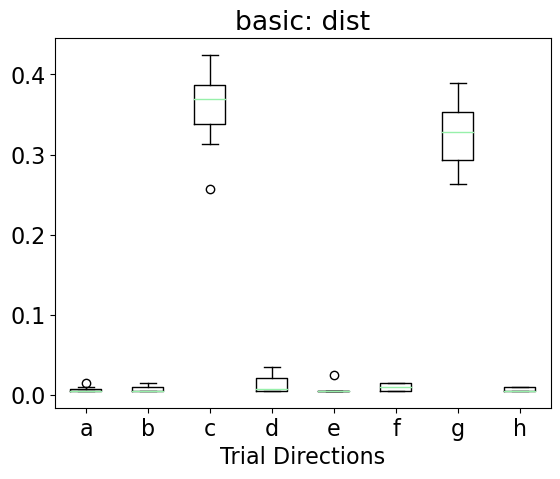

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.5579,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0542,0.0939,0.0,1.0,0.0,0.0,0.0,0.0
5,e,0.832,0.5135,0.0,0.0517,1.0,0.0,0.0,0.0
6,f,0.071,0.2431,0.0,0.2741,0.0932,1.0,0.0,0.0
7,g,0.0,0.0,0.0306,0.0,0.0,0.0,1.0,0.0
8,h,0.7048,0.7644,0.0,0.0681,0.6278,0.1127,0.0,1.0


In [14]:
compare_metrics(:dist, df_hand)
compare_2_directions(:dist)

### Arc Length

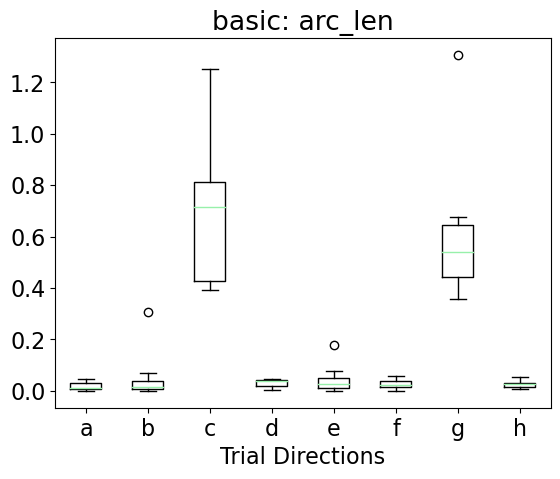

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.2833,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0249,0.5687,0.0,1.0,0.0,0.0,0.0,0.0
5,e,0.1002,0.8076,0.0,0.5312,1.0,0.0,0.0,0.0
6,f,0.2075,0.4491,0.0,0.4565,0.3229,1.0,0.0,0.0
7,g,0.0,0.0,0.2262,0.0,0.0,0.0,1.0,0.0
8,h,0.1298,0.4485,0.0,0.3971,0.3116,0.9836,0.0,1.0


In [15]:
compare_metrics(:arc_len, df_hand)
compare_2_directions(:arc_len)

### Movement Efficiency
total_distance / arc_length

In [16]:
compare_metrics(:mvt_eff, df_hand)
compare_2_directions(:mvt_eff)

LoadError: [91mArgumentError: TDist: the condition ν > zero(ν) is not satisfied.[39m

### Max Error

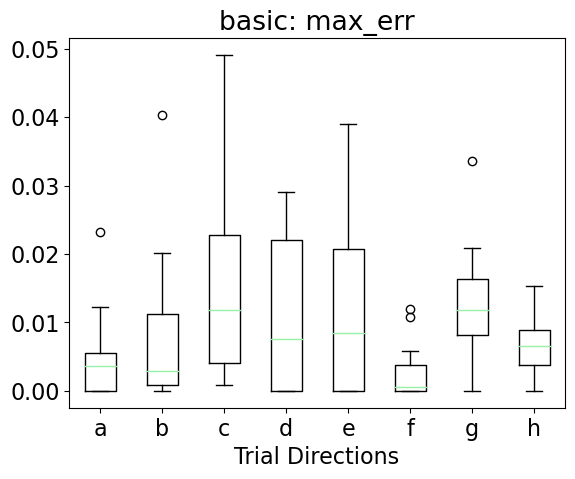

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.4113,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0137,0.1496,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.1254,0.5735,0.3475,1.0,0.0,0.0,0.0,0.0
5,e,0.0802,0.4468,0.4686,0.831,1.0,0.0,0.0,0.0
6,f,0.3577,0.1792,0.0038,0.041,0.0242,1.0,0.0,0.0
7,g,0.0053,0.2413,0.5532,0.5865,0.7787,0.0004,1.0,0.0
8,h,0.402,0.7088,0.0328,0.2631,0.1753,0.0511,0.0183,1.0


In [17]:
compare_metrics(:max_err, df_hand)
compare_2_directions(:max_err)

### Translational Frechet Distance

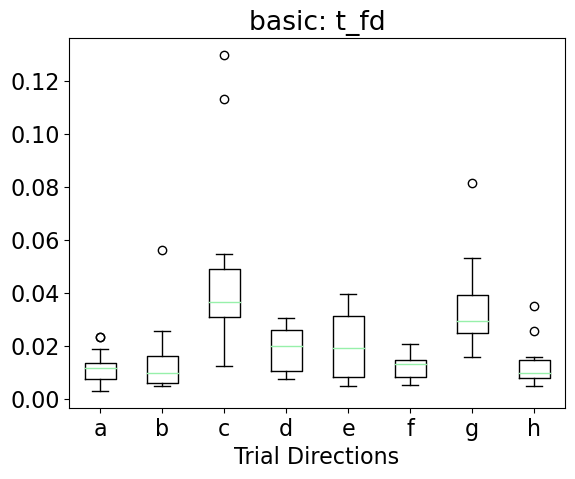

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.5375,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0006,0.0017,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0372,0.4518,0.0033,1.0,0.0,0.0,0.0,0.0
5,e,0.0477,0.3759,0.0047,0.7981,1.0,0.0,0.0,0.0
6,f,0.9925,0.532,0.0006,0.031,0.0428,1.0,0.0,0.0
7,g,0.0001,0.0026,0.1768,0.0031,0.0083,0.0001,1.0,0.0
8,h,0.7043,0.7376,0.0008,0.1417,0.1305,0.6952,0.0002,1.0


In [18]:
compare_metrics(:t_fd, df_hand)
compare_2_directions(:t_fd)

### Max Rotation Error / Rotational Frechet Distance

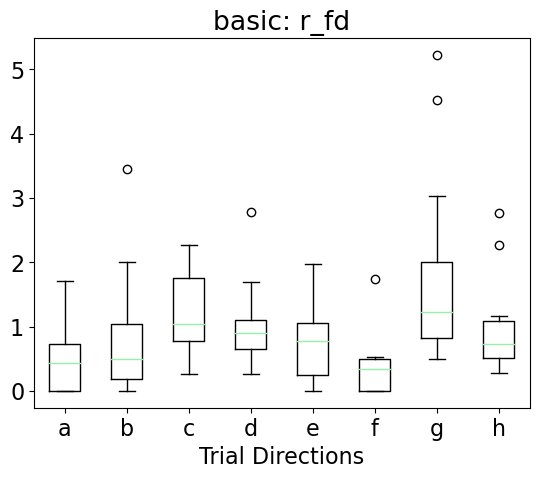

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.3783,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0027,0.2217,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.06,0.5923,0.3754,1.0,0.0,0.0,0.0,0.0
5,e,0.2335,0.9305,0.0593,0.3959,1.0,0.0,0.0,0.0
6,f,0.4566,0.1858,0.0004,0.0158,0.0629,1.0,0.0,0.0
7,g,0.0042,0.0445,0.1728,0.0684,0.0195,0.0018,1.0,0.0
8,h,0.0833,0.6148,0.3985,0.987,0.4385,0.0256,0.0732,1.0


In [19]:
compare_metrics(:r_fd, df_hand)
compare_2_directions(:r_fd)

### Total Area Between Curves
Between object path and target line

In [20]:
compare_metrics(:area_btwn, df_hand)
compare_2_directions(:area_btwn)

LoadError: [91mPyError ($(Expr(:escape, :(ccall(#= /home/cras/.julia/packages/PyCall/tqyST/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>[39m
[91mTypeError("unsupported operand type(s) for +: 'float' and 'PyCall.jlwrap'")[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2448, in boxplot[39m
[91m    is not None else {}))[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py", line 296, in wrapper[39m
[91m    return func(*args, **kwargs)[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1565, in inner[39m
[91m    return func(ax, *map(sanitize_sequence, args), **kwargs)[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 3628, in boxplot[39m
[91m    labels=labels, autorange=autorange)[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 1205, in boxplot_stats[39m
[91m    stats['mean'] = np.mean(x)[39m
[91m  File "<__array_function__ internals>", line 6, in mean[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 3373, in mean[39m
[91m    out=out, **kwargs)[39m
[91m  File "/home/cras/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py", line 160, in _mean[39m
[91m    ret = umr_sum(arr, axis, dtype, out, keepdims)[39m


### Max Area Region
The area between the curves of a scrolling window of about 20% total_distance width.

In [21]:
compare_metrics(:max_a_reg, df_hand)
compare_2_directions(:max_a_reg)

LoadError: [91mArgumentError: TDist: the condition ν > zero(ν) is not satisfied.[39m

### Max Area Location
The location of the center of the max area region, represented as a percentage along the full target line (that is, some percentage of 0.5).

In [22]:
compare_metrics(:max_a_loc, df_hand)
compare_2_directions(:max_a_loc)

LoadError: [91mArgumentError: TDist: the condition ν > zero(ν) is not satisfied.[39m

-----

## Comparing PValues Directly, Direction to Direction, all Metrics

In [23]:
translations = ['a','b','c','d','e','f','g','h']
results_report = zeros(8, 8)

for t in translations
    i = findall(x->x==t, translations)[1]
    n = 0

    for t2 in translations[(i+1):end]
        println(f"{t} v {t2}")
        for m in metrics
            v1, _ = get_trial_vals(df_hand, m, t)
            v2, _ = get_trial_vals(df_hand, m, t2)

            result = pvalue(UnequalVarianceTTest(v1, v2))
            r = round(result, digits=4)
            println(f"{m} => {r}")
        end

        println("  ")
    end
    println("====================")
end

a v b
dist => 0.5579
arc_len => 0.2833


LoadError: [91mMethodError: [0mCannot `convert` an object of type [92mMissing[39m[0m to an object of type [91mFloat64[39m[39m
[91m[0mClosest candidates are:[39m
[91m[0m  convert(::Type{T}, [91m::T[39m) where T<:Number at number.jl:6[39m
[91m[0m  convert(::Type{T}, [91m::Number[39m) where T<:Number at number.jl:7[39m
[91m[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number at twiceprecision.jl:250[39m
[91m[0m  ...[39m

In [24]:
function aggregate_pvalues()
    translations = ['a','b','c','d','e','f','g','h']
    results_report = zeros(8, 8)
    
    for t in translations
        i = findall(x->x==t, translations)[1]
        n = 0
        
        for t2 in translations[i:end]
            total_sigs = 0
            
            for m in metrics
                v1, _ = get_trial_vals(df_hand, m, t)
                v2, _ = get_trial_vals(df_hand, m, t2)

                result = pvalue(UnequalVarianceTTest(v1, v2))
                
                if result <= 0.05
                    total_sigs = total_sigs + 1
                end
                
                if t == t2
                    total_sigs = NaN
                end
            end
            perc_sigs = total_sigs / length(metrics)
            results_report[i, i+n] = perc_sigs
            
            n = n+1
        end
        println(" ")
    end

    r_df = DataFrame(trials=translations = ["a", "b", "c", "d", "e", "f", "g", "h"], 
                     a=results_report[1,:], b=results_report[2,:], c=results_report[3,:],
                     d=results_report[4,:], e=results_report[5,:], f=results_report[6,:],
                     g=results_report[7,:], h=results_report[8,:])
    
    return r_df
end

aggregate_results = aggregate_pvalues()
# CSV.write(aggregate_results)
aggregate_results

LoadError: [91mMethodError: [0mCannot `convert` an object of type [92mMissing[39m[0m to an object of type [91mFloat64[39m[39m
[91m[0mClosest candidates are:[39m
[91m[0m  convert(::Type{T}, [91m::T[39m) where T<:Number at number.jl:6[39m
[91m[0m  convert(::Type{T}, [91m::Number[39m) where T<:Number at number.jl:7[39m
[91m[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number at twiceprecision.jl:250[39m
[91m[0m  ...[39m

In [25]:
colormap = PyPlot.matplotlib.cm.get_cmap("bwr")
colors = colormap.(reverse(range(0.1, stop=0.9, length=10)))

10-element Array{NTuple{4,Float64},1}:
 (1.0, 0.196078431372549, 0.196078431372549, 1.0)
 (1.0, 0.3764705882352941, 0.3764705882352941, 1.0)
 (1.0, 0.5568627450980392, 0.5568627450980392, 1.0)
 (1.0, 0.7294117647058824, 0.7294117647058824, 1.0)
 (1.0, 0.9098039215686274, 0.9098039215686274, 1.0)
 (0.9098039215686274, 0.9098039215686274, 1.0, 1.0)
 (0.7294117647058823, 0.7294117647058823, 1.0, 1.0)
 (0.5568627450980392, 0.5568627450980392, 1.0, 1.0)
 (0.3764705882352941, 0.3764705882352941, 1.0, 1.0)
 (0.19607843137254902, 0.19607843137254902, 1.0, 1.0)

In [26]:
# make a nice table with color coding, highlighting directions that have and don't have significant differences from each other

fig, ax = subplots()

# Hide axes because there isn't a plot to go with it
ax.axis("off")

results_table = convert(Matrix, aggregate_results)
# the_table = table(results_table, colLabels=names(aggregate_results))

# the_table.get_celld()[(1,0)].set_facecolor("#56b5fd")

# colormap = PyPlot.matplotlib.cm.get_cmap("bwr")

# for i in range(1, stop=8)
#     for j in range(1, stop=9)
#         val = aggregate_results[i,j]
        
#         if typeof(val) == String
#             c = "xkcd:grey blue"
#         elseif isnan(val)
#             c = "xkcd:dark grey"
#         else
#             c = colormap(val)
#         end
        
#         the_table.get_celld()[(i-1,j-1)].set_facecolor(c)
#     end
# end


LoadError: [91mUndefVarError: aggregate_results not defined[39m

![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

# Clustering for Symmetry

In [27]:
using Clustering

# use kmeans or hierarchical clustering single linkage?

In [28]:
test = [1, 2, 3, 4, 5]
t = 2
i = findall(x->x!=t, test)

4-element Array{Int64,1}:
 1
 3
 4
 5